In [1]:
from tools.checkpoint import model_from_checkpoint

device = 'mps'
model, _ = model_from_checkpoint("/Users/jonathanmiddleton/models/checkpoints/650m-sft/20251124T1715-val1.800-step003111-tokens1000064-run0-final.pt", device=device)

In [2]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def token_entropies_from_logits(logits, base='e'):
    """
    logits: Tensor [seq_len, vocab_size]
    returns: Tensor [seq_len] of entropies per position
    """
    # logits -> probabilities
    log_probs = F.log_softmax(logits, dim=-1)            # [seq_len, vocab]
    probs = log_probs.exp()                              # [seq_len, vocab]

    # entropy per position: -sum p log p
    ent = -(probs * log_probs).sum(dim=-1)               # [seq_len]

    if base == '2':
        ent = ent / math.log(2.0)
    elif base == '10':
        ent = ent / math.log(10.0)

    return ent  # in nats (or bits / log10 if base != 'e')


def visualize_entropy_for_prompt(prompt, model, tokenizer, device: str = 'mps', base='e'):
    """
    Compute and plot token-wise entropy for a prompt.
    """
    model.eval(,

    # Encode prompt
    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"]
    input_ids = input_ids.squeeze().to(device)

    with torch.no_grad():
        one = torch.tensor(1, device=device, dtype=torch.int32)
        logits = model(input_seq=input_ids, sliding_window_num_blocks=one, output_logits=True)
        logits = logits.squeeze()


    ent = token_entropies_from_logits(logits, base=base).cpu()

    # for x-axis labels
    token_ids = input_ids.cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    plt.figure(figsize=(max(8, len(tokens) * 0.4), 3))
    plt.plot(range(len(tokens)), ent.numpy(), marker='o')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel(f"Entropy (base {base})")
    plt.xlabel("Token index")
    plt.title("Token-wise entropy")
    plt.tight_layout()
    plt.show()

    return tokens, ent


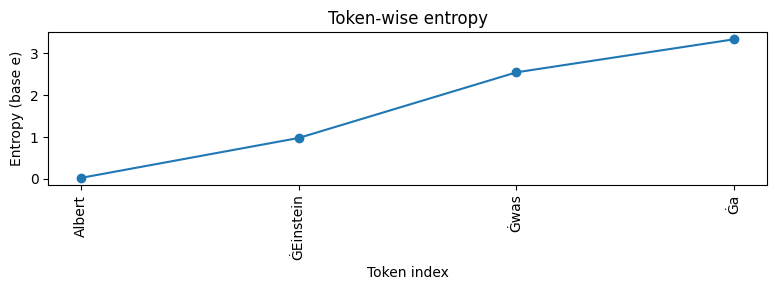

In [3]:
from transformers import AutoTokenizer

prompt = "Albert Einstein was a"
tokenizer = tok = AutoTokenizer.from_pretrained('gpt2', use_fast=True, model_max_length=1_000_000)
tokens, ent = visualize_entropy_for_prompt(
    prompt,
    model,
    tokenizer,
)
